# Novel ML Problem
## HIMANSH ARORA

# Research Question

How does the Crime Rate in the different Counties of Ireland affect the Property Prices in those counties in a given Quarter?<br><br>

In this project, we explore the various crime related statistics that might influence Average Sales Prices.<br><br>

We perform extensive data merging, preprocessing, and cleaning, along with pipelines for feature engineering. We train and evaluate different hyperparameter configurations for 3 different models, and study their RMSE, MAE, and, R^2 values to optimize model performance and identify the most optimal parameters.

## Import Libraries

Let us import all the necessary libraries.

In [ ]:
import pandas as pd
import re
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

Let us load both the datasets.

In [ ]:
# Load crime dataset
crime_data = pd.read_csv("recorded_crime_ireland.csv")

# Load property price dataset
property_data = pd.read_csv("Property_Price_Register_Ireland-28-05-2021.csv")

# Display the first few rows of each dataset
print("Crime Data:")
display(crime_data.head())

print("\nProperty Price Data:")
display(property_data.tail())

Crime Data:


,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded Crime Offences under Reservation,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1
1,Recorded Crime Offences under Reservation,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0
2,Recorded Crime Offences under Reservation,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0
3,Recorded Crime Offences under Reservation,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0
4,Recorded Crime Offences under Reservation,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1



Property Price Data:


,SALE_DATE,ADDRESS,POSTAL_CODE,COUNTY,SALE_PRICE,IF_MARKET_PRICE,IF_VAT_EXCLUDED,PROPERTY_DESC,PROPERTY_SIZE_DESC
476740,2021-05-28,"GRANGE STORES, GRANGE, MULLINGAR",NaN,Westmeath,150000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
476741,2021-05-28,"MAIN STREET, LOWER BORRIS, BORRIS",NaN,Carlow,170000.0,1,0,Second-Hand Dwelling house /Apartment,NaN
476742,2021-05-28,"MULTYFARNHAM, WESTMEATH",NaN,Westmeath,175000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
476743,2021-05-28,"NO 2 RIVERLODGE, SHRONE, GLENGARIFF",NaN,Cork,240000.0,0,0,Second-Hand Dwelling house /Apartment,NaN
476744,2021-05-28,"RABANE, KILL, COOTEHILL",NaN,Cavan,47000.0,0,0,Second-Hand Dwelling house /Apartment,NaN


## Study the Datasets

In [ ]:
print(crime_data.shape)
print(property_data.shape)

(157052, 6)
(476745, 9)


In [ ]:
print("Crime Data Garda Divisions\n\n",crime_data["Garda Division"].unique())
print("\n\nProperty Data Garda County\n",property_data["COUNTY"].unique())

Crime Data Garda Divisions

 ['Cavan/Monaghan Garda Division' 'Donegal Garda Division'
 'Sligo/Leitrim Garda Division' 'Louth Garda Division'
 'Clare Garda Division' 'Mayo Garda Division' 'Galway Garda Division'
 'Roscommon/Longford Garda Division' 'Cork City Garda Division'
 'Cork North Garda Division' 'Cork West Garda Division'
 'Kerry Garda Division' 'Limerick Garda Division'
 'Laois/Offaly Garda Division' 'Meath Garda Division'
 'Wicklow Garda Division' 'Westmeath Garda Division'
 'Kildare Garda Division' 'Tipperary Garda Division'
 'Wexford Garda Division' 'Kilkenny/Carlow Garda Division'
 'Waterford Garda Division' 'D.M.R. South Central Garda Division'
 'D.M.R. North Central Garda Division' 'D.M.R. Northern Garda Division'
 'D.M.R. Southern Garda Division' 'D.M.R. Eastern Garda Division'
 'D.M.R. Western Garda Division']


Property Data Garda County
 ['Dublin' 'Laois' 'Meath' 'Kilkenny' 'Limerick' 'Carlow' 'Cork' 'Clare'
 'Sligo' 'Cavan' 'Tipperary' 'Wicklow' 'Roscommon' 'Wexford

## Merging the Datasets

1. **`crime_data`**: Has columns `Quarter` and `Garda Division`. We perform mapping to introduce a column called `County` to match with Counties present in `property_data`.<br><br>

2. **`property_data`**: Has columns `Date` and `COUNTY`. We extract `Quarter` from `Date` and introduce it as a new column to match with `crime_data`. <br><br>

3. **Aggregating**: We aggregate the crime dataset on `Quarter`, `Type of Offence`, and `County`, by the sum of `Total crime`. We also aggregate the property data on `Quarter`, `COUNTY`, and `PROPERTY_DESC` by the `Avg_Sale_Price`.<br><br>

4. **Merging**: We merge the 2 datasets on `COUNTY`, and `Quarter`.

In [ ]:
# Convert SALE_DATE to datetime and extract Quarter
property_data['SALE_DATE'] = pd.to_datetime(property_data['SALE_DATE'], errors='coerce')
property_data['Quarter'] = property_data['SALE_DATE'].dt.to_period('Q').astype(str)

# Replace joint regions in property_data to match Garda Divisions
def replace_countyName(data, column_name):
    if column_name not in data.columns:
        print(f"Error: Column '{column_name}' not found.")
        return data

    # Mapping grouped counties to joint divisions
    replacements = {
        'Cavan': 'Cavan/Monaghan',
        'Monaghan': 'Cavan/Monaghan',
        'Sligo': 'Sligo/Leitrim',
        'Leitrim': 'Sligo/Leitrim',
        'Roscommon': 'Roscommon/Longford',
        'Longford': 'Roscommon/Longford',
        'Laois': 'Laois/Offaly',
        'Offaly': 'Laois/Offaly',
        'Kilkenny': 'Kilkenny/Carlow',
        'Carlow': 'Kilkenny/Carlow'
    }

    data[column_name] = data[column_name].replace(replacements)
    return data

property_data = replace_countyName(property_data, 'COUNTY')

# Garda Division → County mapping (corrected for all divisions including Dublin)
garda_to_county = {
    'D.M.R. South Central Garda Division': 'Dublin',
    'D.M.R. North Central Garda Division': 'Dublin',
    'D.M.R. Northern Garda Division': 'Dublin',
    'D.M.R. Southern Garda Division': 'Dublin',
    'D.M.R. Eastern Garda Division': 'Dublin',
    'D.M.R. Western Garda Division': 'Dublin',
    'Meath Garda Division': 'Meath',
    'Laois/Offaly Garda Division': 'Laois',
    'Kilkenny/Carlow Garda Division': 'Kilkenny',
    'Cork City Garda Division': 'Cork',
    'Galway Garda Division': 'Galway',
    'Limerick Garda Division': 'Limerick',
    'Wexford Garda Division': 'Wexford',
    'Waterford Garda Division': 'Waterford',
    'Kerry Garda Division': 'Kerry',
    'Mayo Garda Division': 'Mayo',
    'Clare Garda Division': 'Clare',
    'Westmeath Garda Division': 'Westmeath',
    'Wicklow Garda Division': 'Wicklow',
    'Donegal Garda Division': 'Donegal',
    'Tipperary Garda Division': 'Tipperary',
    'Sligo/Leitrim Garda Division': 'Sligo',
    'Roscommon/Longford Garda Division': 'Roscommon',
    'Cavan/Monaghan Garda Division': 'Cavan'
}

# Map Garda Division to County in crime_data
crime_data['COUNTY'] = crime_data['Garda Division'].map(garda_to_county)

# Filter crime_data to years 2010–2021
crime_data['Year'] = crime_data['Quarter'].str[:4].astype(int)
crime_data = crime_data[(crime_data['Year'] >= 2010) & (crime_data['Year'] <= 2021)]

# Aggregate crime data
crime_agg = (
    crime_data.groupby(['Quarter', 'COUNTY', 'Type of Offence'], as_index=False)['VALUE']
    .sum()
    .rename(columns={'VALUE': 'Total_Crimes'})
)

# Aggregate property data
property_agg = (
    property_data.groupby(['Quarter', 'COUNTY','PROPERTY_DESC'], as_index= False)['SALE_PRICE']
    .mean()
    .rename(columns={'SALE_PRICE': 'Avg_Sale_Price'})
)

# Merge datasets on Quarter and COUNTY
merged_data = pd.merge(
    crime_agg,
    property_agg,
    on=['Quarter', 'COUNTY'],
    how='left'
)

merged_data.to_csv("merged_data.csv")

# Final merged output
print("Merged dataset shape:", merged_data.shape)
merged_data.tail()

Merged dataset shape: (112464, 6)


,Quarter,COUNTY,Type of Offence,Total_Crimes,PROPERTY_DESC,Avg_Sale_Price
112459,2021Q4,Wicklow,Theft/taking of vehicle and related offences,12,NaN,NaN
112460,2021Q4,Wicklow,Threat to kill or cause serious harm,3,NaN,NaN
112461,2021Q4,Wicklow,Trespass offences,10,NaN,NaN
112462,2021Q4,Wicklow,Unseaworthy/dangerous use of boat or ship,0,NaN,NaN
112463,2021Q4,Wicklow,Weapons and Explosives Offences,5,NaN,NaN


## 1.2.1 Data Preprocessing and Feature Engineering

### Missing Values

First we handle missing values in the dataset.

In [ ]:
merged_data.isnull().sum()

Quarter                0
COUNTY                 0
Type of Offence        0
Total_Crimes           0
PROPERTY_DESC      19028
Avg_Sale_Price     19028
dtype: int64

In [ ]:
# Replace Nan values in Avg_Sale_Price with the average of the column
merged_data['Avg_Sale_Price'].fillna((merged_data['Avg_Sale_Price'].mean()), inplace=True)

In [ ]:
# Check unique values in PROPERTY_DESC
merged_data["PROPERTY_DESC"].unique()

array([nan, 'New Dwelling house /Apartment',
       'Second-Hand Dwelling house /Apartment',
       'Teach/�ras�n C�naithe Ath�imhe', 'Teach/�ras�n C�naithe Nua',
       'Teach/?ras?n C?naithe Nua'], dtype=object)

In [ ]:
# Replace the non-sensical values in PROPERTY_DESC with meaningful entries

#Writing a function to translate the property names that are in Gaelic to English.
def translate_irish_property_type(irish_string):

    if pd.isna(irish_string):
        return irish_string  # Just return NaN as-is
    if re.search(r"Nua", irish_string, re.IGNORECASE):
        return "New Residential house/Apartment"
    elif re.search(r"Ath", irish_string, re.IGNORECASE):
        return "Second-Hand Residential house/Apartment"
    else:
        return irish_string


#applying the translate funtion to change the property description from Gaelic to English.
merged_data['PROPERTY_DESC'] = merged_data['PROPERTY_DESC'].apply(translate_irish_property_type)

#displaying the unique values of the property description to double check the function.
print("\nDataFrame with translations:")
merged_data['PROPERTY_DESC'].unique()


DataFrame with translations:


array([nan, 'New Dwelling house /Apartment',
       'Second-Hand Dwelling house /Apartment',
       'Second-Hand Residential house/Apartment',
       'New Residential house/Apartment'], dtype=object)

In [ ]:
# Fill NaNs with that most common value/ mode of the column
merged_data['PROPERTY_DESC'] = merged_data['PROPERTY_DESC'].fillna(merged_data['PROPERTY_DESC'].mode()[0])

In [ ]:
merged_data.isnull().sum()

Quarter            0
COUNTY             0
Type of Offence    0
Total_Crimes       0
PROPERTY_DESC      0
Avg_Sale_Price     0
dtype: int64

### Outliers

We also check for outliers. Since, the number of outliers is significantly lower than the size of the dataset, we decide to drop these outliers.

In [ ]:
num_cols = ["Avg_Sale_Price", "Total_Crimes"]

# Calculate the zscore for the numerical variables in drugs dataframe
z_scores = merged_data[num_cols].apply(zscore)
# Any zscores above 3 fall into the category of outliers
# store them as outliers
outliers = (z_scores.abs() > 3).sum()
# Print the number of outliers in each column
print("\nNumber of Outliers in Each Column (Z-score > 3):")
print(outliers)


Number of Outliers in Each Column (Z-score > 3):
Avg_Sale_Price    1846
Total_Crimes      1346
dtype: int64


In [ ]:
# Combine numerical columns
z_scores = np.abs(zscore(merged_data[['Avg_Sale_Price', 'Total_Crimes']]))
mask = (z_scores < 3).all(axis=1)  # Keep only rows where both columns have z < 3

# Filter out outliers
merged_data = merged_data[mask]

# EDA

Next we perform and analyze the data visually through Exploratory Data Analysis.

## Numerical Distribution

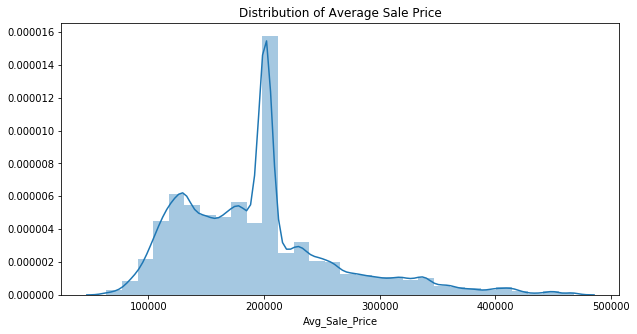

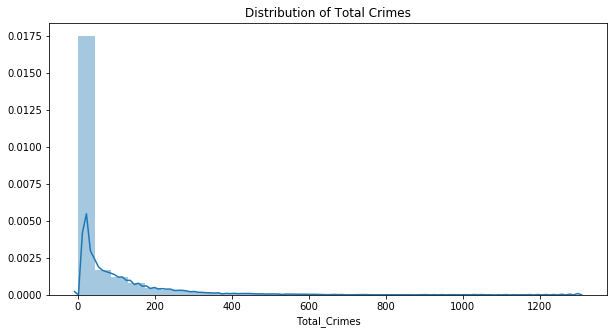

In [ ]:
merged_data['Year'] = merged_data['Quarter'].str.extract(r'(\d{4})').astype('str')

# Distribution of target variable
plt.figure(figsize=(10,5))
sns.distplot(merged_data['Avg_Sale_Price'], kde=True, bins=30)
plt.title("Distribution of Average Sale Price")
plt.show()

# Distribution of crimes
plt.figure(figsize=(10,5))
sns.distplot(merged_data['Total_Crimes'], kde=True, bins=30)
plt.title("Distribution of Total Crimes")
plt.show()

# Interpretation

Both `Avg_Sale_Price`, and `Total_Crimes` look left skewed with maximum average property prices situated around 200,000 euros, and maximum number of crimes between 0-500.

# Categorical Count

In [ ]:
# Loop through categorical columns
categorical_cols = ['PROPERTY_DESC', 'COUNTY', 'Quarter', 'Type of Offence']

for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(merged_data[col].value_counts())


Value Counts for PROPERTY_DESC:
New Dwelling house /Apartment              63300
Second-Hand Dwelling house /Apartment      44687
Second-Hand Residential house/Apartment     1345
New Residential house/Apartment              200
Name: PROPERTY_DESC, dtype: int64

Value Counts for COUNTY:
Meath        6887
Donegal      6816
Waterford    6816
Limerick     6745
Cork         6745
Wexford      6745
Clare        6745
Tipperary    6674
Galway       6674
Westmeath    6674
Mayo         6674
Kerry        6603
Wicklow      6532
Dublin       5162
Sligo        3408
Roscommon    3408
Laois        3408
Kilkenny     3408
Cavan        3408
Name: COUNTY, dtype: int64

Value Counts for Quarter:
2015Q3    2446
2014Q4    2394
2013Q4    2392
2018Q3    2388
2017Q1    2388
2016Q3    2388
2010Q4    2386
2019Q2    2386
2010Q1    2384
2012Q3    2384
2012Q4    2384
2013Q2    2381
2013Q3    2381
2014Q3    2381
2011Q2    2378
2016Q2    2375
2012Q2    2375
2012Q1    2375
2010Q3    2369
2013Q1    2323
2014Q1    2323


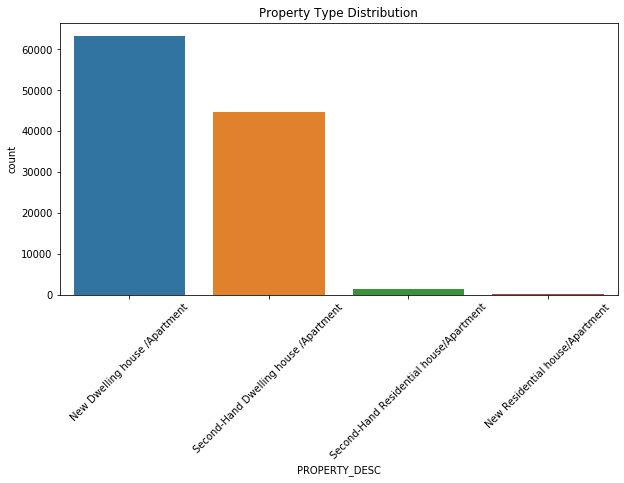

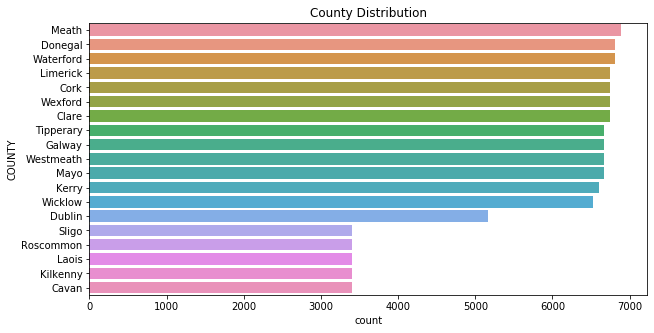

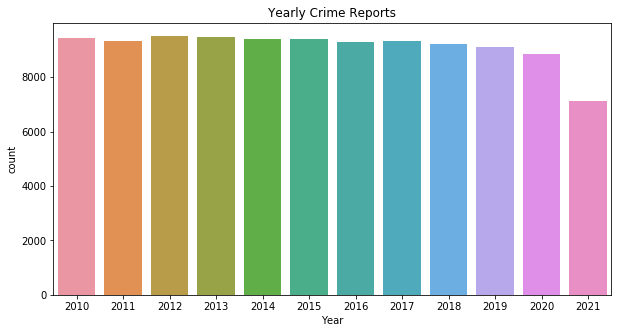

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Property Description Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_data, x='PROPERTY_DESC', order=merged_data['PROPERTY_DESC'].value_counts().index)
plt.title("Property Type Distribution")
plt.xticks(rotation=45)
plt.show()

# County Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_data, y='COUNTY', order=merged_data['COUNTY'].value_counts().index)
plt.title("County Distribution")
plt.show()

# Year Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_data, x='Year', order=sorted(merged_data['Year'].unique()))
plt.title("Yearly Crime Reports")
plt.show()

# Interpretation

From the numerical and graphical outputs, the categorical varibale of highest concern is `PROPERTY_DESC` where Second-hand Residential House/Apartement, and New Residential House/Apartement have almost negligent entries. <br><br>

Similarly for `COUNTY`, Kilkenny, Roscommon, Sligo, and Laois seem to have slightly less count than the rest of the counties. This cuases class imbalance in the dataset, and might lead to misinformed results.

# Bivariate and Multivariate Analysis

We now study the relationship between different variables in the dataset and try to gather insights.

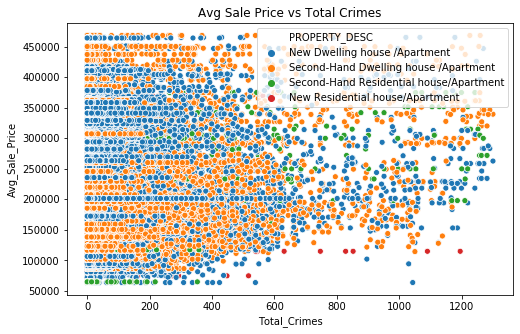

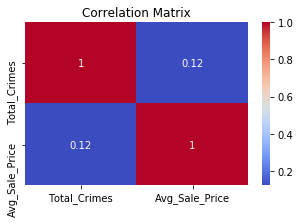

In [ ]:
# Avg price vs total crime
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_data, x='Total_Crimes', y='Avg_Sale_Price', hue='PROPERTY_DESC')
plt.title("Avg Sale Price vs Total Crimes")
plt.show()

# Correlation heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Interpretation

1. **`Avg_Sales_Price` vs `Total_Crimes`**:The above graph shows how Average Sales Prices are affected by Total Crimes based on the type of property. The graph highlights no significant relationship between Total Crimes, and Average Sales Price. We also visualize that there are no stringly defined clusters of property type, and they tend to overlap each other.<br><br>

2. **Correlation**: There seems to be very weak positive correlation between Total Crimes and Average Sales Price.

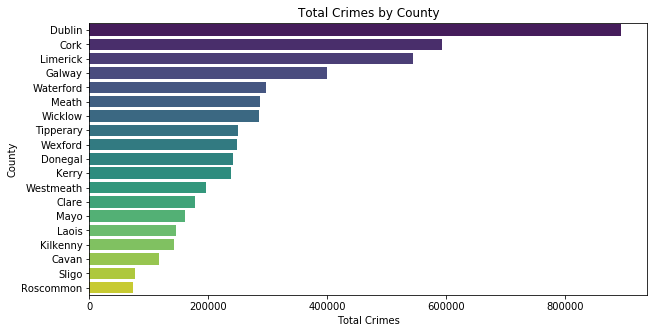

In [ ]:
crime_by_county = merged_data.groupby('COUNTY')['Total_Crimes'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=crime_by_county.values, y=crime_by_county.index, palette='viridis')
plt.title("Total Crimes by County")
plt.xlabel("Total Crimes")
plt.ylabel("County")
plt.show()

# Interpretation

The graph above shows the total count for crime for each county. It is visible that there is a significant amount of crime reported in Dublin, which is much higher than the rest of the counties.

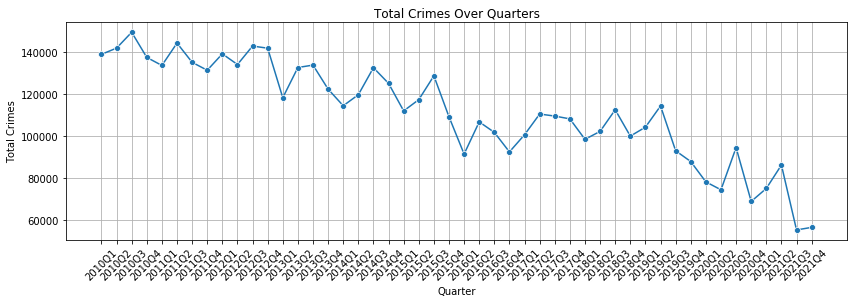

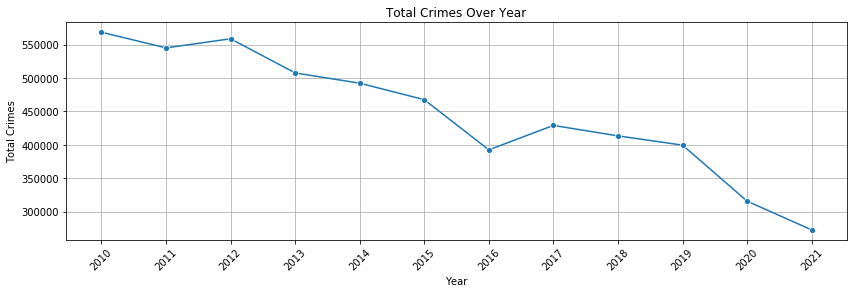

In [ ]:
crime_by_quarter = merged_data.groupby('Quarter')['Total_Crimes'].sum().sort_index()

plt.figure(figsize=(14, 4))
sns.lineplot(x=crime_by_quarter.index, y=crime_by_quarter.values, marker='o')
plt.title("Total Crimes Over Quarters")
plt.xlabel("Quarter")
plt.ylabel("Total Crimes")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

crime_by_year = merged_data.groupby('Year')['Total_Crimes'].sum().sort_index()

plt.figure(figsize=(14, 4))
sns.lineplot(x=crime_by_year.index, y=crime_by_year.values, marker='o')
plt.title("Total Crimes Over Year")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Interpretation

From the above graphs, we can notice how the cirme rate drastically decreases in 2019-2021 (during COVID). If we look at the Quarters, the number of total crimes varies, but decreases after 2019.

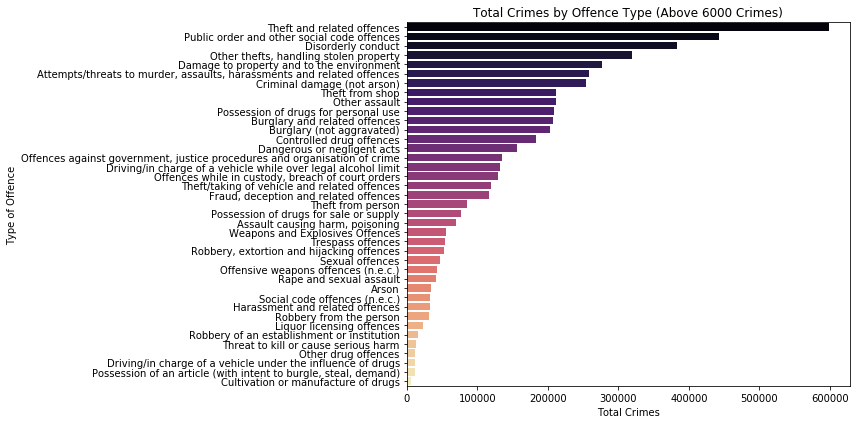

In [ ]:
# Group and sort offence types by total crimes
crime_by_type = merged_data.groupby('Type of Offence')['Total_Crimes'].sum().sort_values(ascending=False)

# Filter for offence types with more than 1000 total crimes
crime_by_type_filtered = crime_by_type[crime_by_type > 6000]

# Plot
plt.figure(figsize=(12, 6))
#sns.barplot(x=crime_by_type.values, y=crime_by_type.index, palette='magma')
sns.barplot(x=crime_by_type_filtered.values, y=crime_by_type_filtered.index, palette='magma')
plt.title("Total Crimes by Offence Type (Above 6000 Crimes)")
plt.xlabel("Total Crimes")
plt.ylabel("Type of Offence")
plt.tight_layout()
plt.show()

# Interpretation

Above, we have the total number of crimes based on Tyoes of Offence, and since there is a huge number of categories in this variable, we have visualized the ones that have reported crimes above 6000.

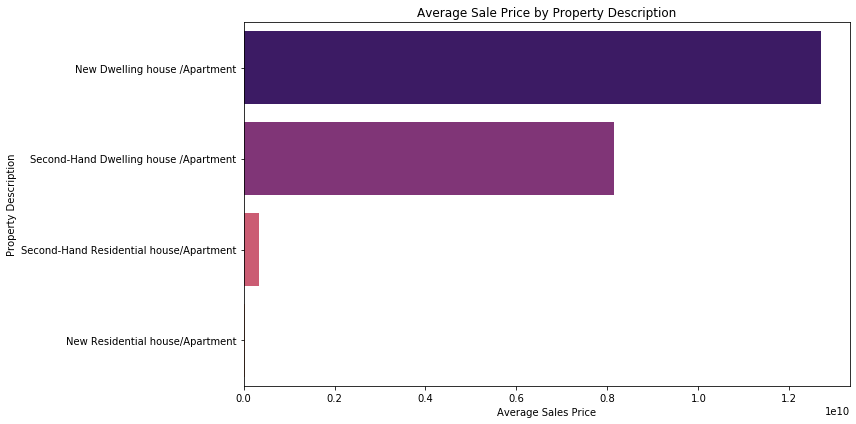

In [ ]:
price_by_property = merged_data.groupby('PROPERTY_DESC')['Avg_Sale_Price'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=price_by_property.values, y=price_by_property.index, palette='magma')
plt.title("Average Sale Price by Property Description")
plt.xlabel("Average Sales Price")
plt.ylabel("Property Description")
plt.tight_layout()
plt.show()

# Interpretation

Due to the previously observed low number of entries in Second-Hande Residential House/Apartment, and New Residential House/Apartment, it is easy to understand why these 2 categories have a much lower Average Price.

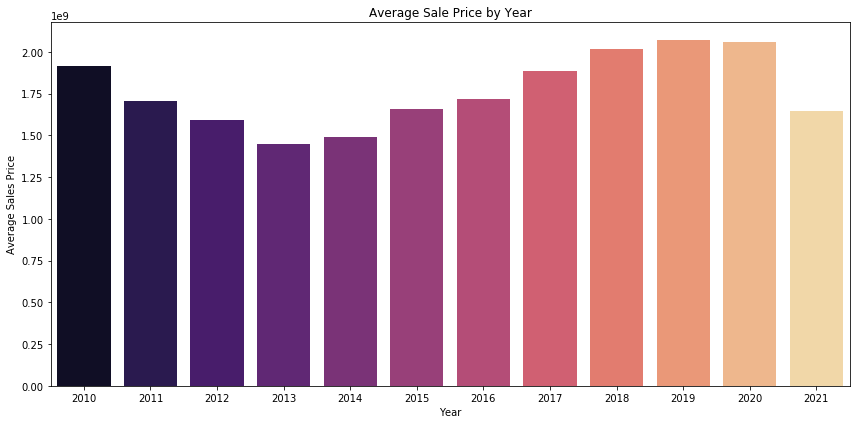

In [ ]:
price_by_year = merged_data.groupby('Year')['Avg_Sale_Price'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=price_by_year.index, y=price_by_year.values, palette='magma')
plt.title("Average Sale Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Sales Price")
plt.tight_layout()
plt.show()

# Interpretation

The average sale price is lowest in 2013 when crime rate is really high, and is highest in 2019-22, when the crime rate is decreasing steeply.

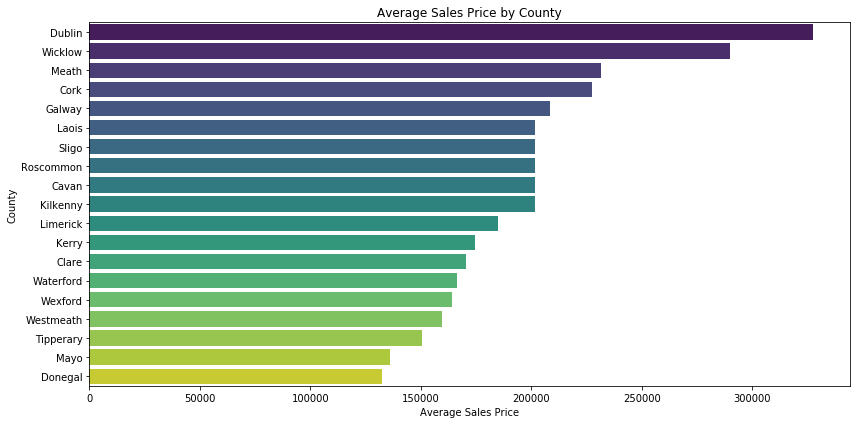

In [ ]:
avg_price_by_county = merged_data.groupby('COUNTY')['Avg_Sale_Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_by_county.values, y=avg_price_by_county.index, palette='viridis')
plt.title("Average Sales Price by County")
plt.xlabel("Average Sales Price")
plt.ylabel("County")
plt.tight_layout()
plt.show()

# Interpretation

The county with highest average sales price is Dublin, even though we previously observed that Dublin has the highest crime report. This is followed closely by Wicklow which has a muc lower crime rate. The rest of the counties have a much closer and similar price range.

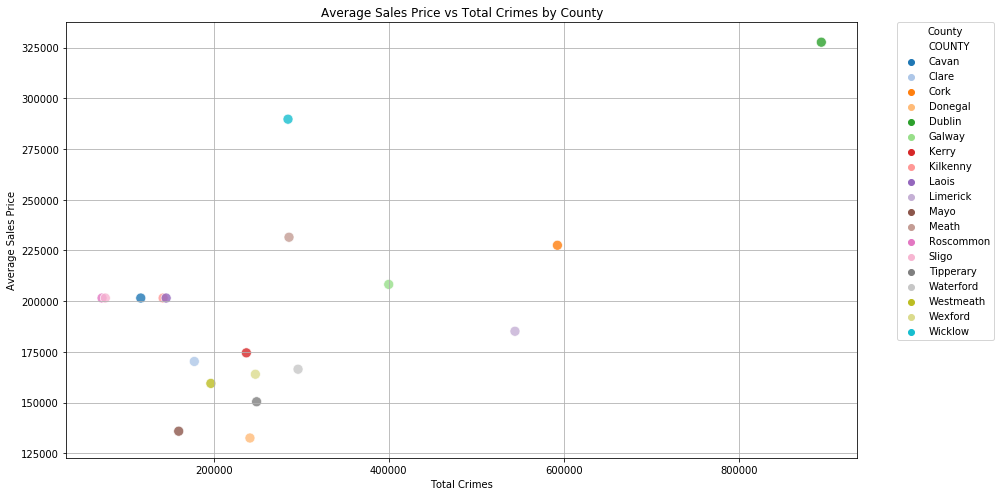

In [ ]:
# Group data by County: get total crimes and average price
county_summary = merged_data.groupby('COUNTY').agg({
    'Total_Crimes': 'sum',
    'Avg_Sale_Price': 'mean'
}).reset_index()

plt.figure(figsize=(14, 7))
scatter = sns.scatterplot(
    data=county_summary,
    x='Total_Crimes',
    y='Avg_Sale_Price',
    hue='COUNTY',
    palette='tab20',
    s=100,
    alpha=0.8
)

plt.title("Average Sales Price vs Total Crimes by County")
plt.xlabel("Total Crimes")
plt.ylabel("Average Sales Price")
plt.grid(True)

# Position the legend outside the plot for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='County', borderaxespad=0.)
plt.tight_layout()
plt.show()

# Interpretation

The graph above shows the relation between aggregated Total Crimes and Average Sales Price by County. It can be seen that there is a very slight positive linear relationship. The outlier is Dublin with extremely high Crime and Average Sales Price.

In [ ]:
merged_data.describe()

,Total_Crimes,Avg_Sale_Price
count,109532.000000,109532.000000
mean,48.955858,193586.009947
std,115.969608,68529.706267
min,0.000000,63874.874468
25%,0.000000,142195.165278
50%,4.000000,193385.683187
75%,40.000000,215562.226609
max,1300.000000,468407.604590


# Feature Engineering

1. We upsample the minority classes in the dataset to handle class imbalance.
2. We standardize the numerical variables, and encode the categorical variables.
3. We create a pipeline to optimize the preprocessing and feature engineering steps.

In [ ]:
from sklearn.utils import resample

# Split majority and minority classes
df_majority = merged_data[merged_data['PROPERTY_DESC'] == 'New Dwelling house /Apartment']
dfs_minority = [merged_data[merged_data['PROPERTY_DESC'] == label]
                for label in merged_data['PROPERTY_DESC'].unique()
                if label != 'New Dwelling house /Apartment']

# Upsample each minority class to match the majority class
upsampled = [resample(df,
                      replace=True,
                      n_samples=len(df_majority),
                      random_state=42)
             for df in dfs_minority]

# Combine back
merged_data = pd.concat([df_majority] + upsampled)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Encode categorical variables
categorical_cols = ['PROPERTY_DESC', 'COUNTY', 'Type of Offence', 'Quarter']
numerical_cols = ['Total_Crimes']

# Split dataset
X = merged_data[categorical_cols + numerical_cols]
y = merged_data['Avg_Sale_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

## Modeling, Evaluation, and Comparison Plots

For this data, we have decided to explore the following 3 models:

1. Linear SVM
2. Random Forest Regression
3. Gradient Boosting Regression

We then plot the RMSE values of different hyperparameter combinations for each model.<br><br>

Finally, we study and compare the RMSE, MAE, and , R^2 values of the best hyperparameter configurations for each model.


Running GridSearchCV for Random Forest...

Running GridSearchCV for Gradient Boosting...

Running GridSearchCV for Linear SVM...


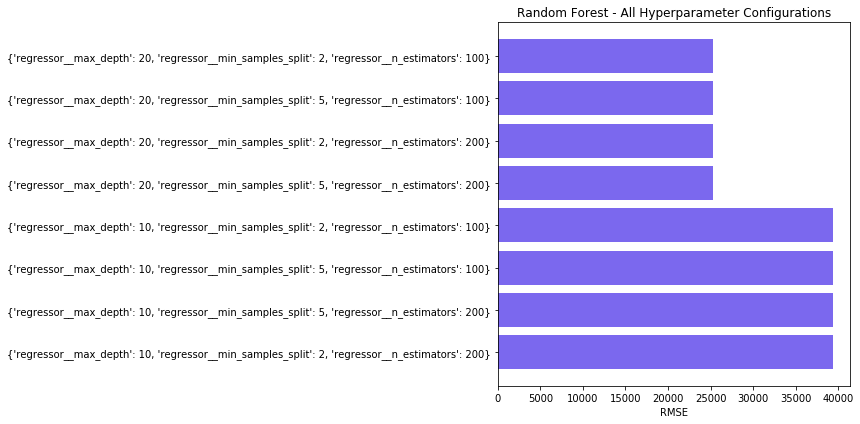

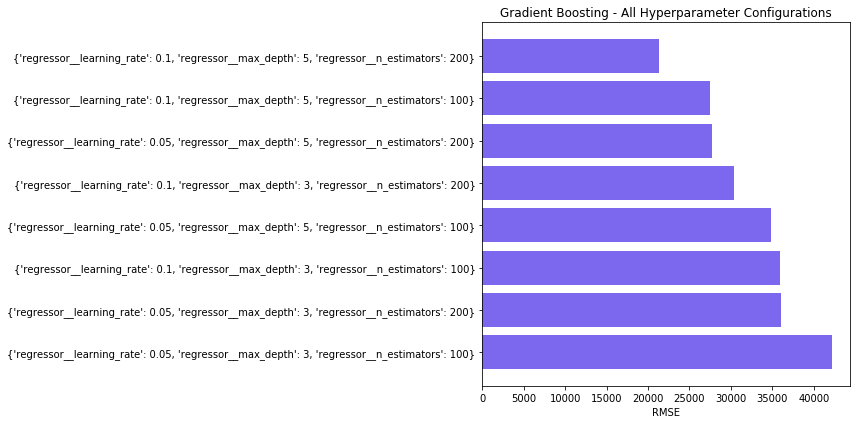

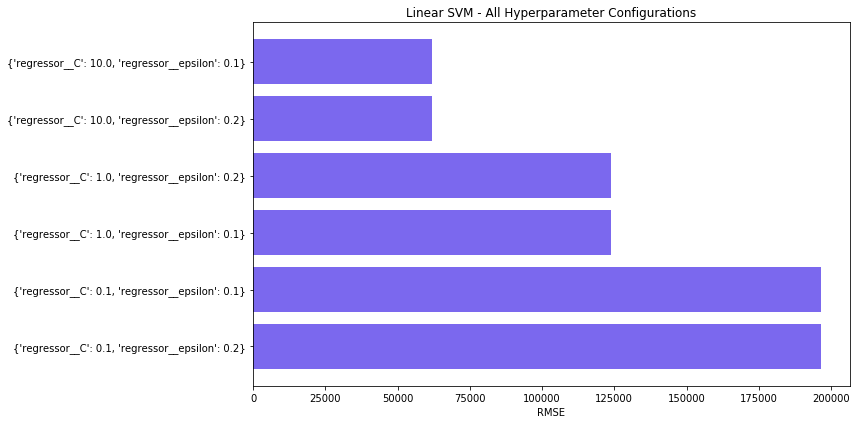

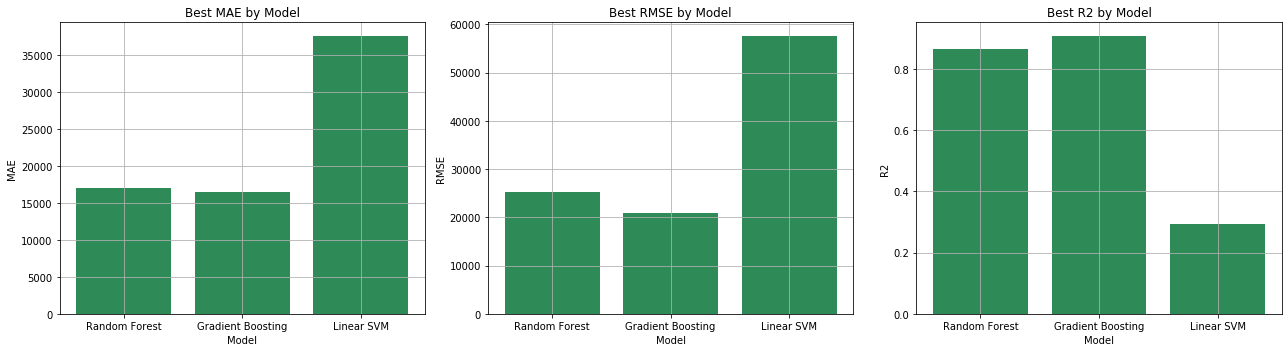

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models and hyperparameter grids
models_and_params = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [100, 200],
            "regressor__max_depth": [10, 20],
            "regressor__min_samples_split": [2, 5]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [100, 200],
            "regressor__learning_rate": [0.05, 0.1],
            "regressor__max_depth": [3, 5]
        }
    },
    "Linear SVM": {
        "model": LinearSVR(random_state=42, max_iter=10000),
        "params": {
            "regressor__C": [0.1, 1.0, 10.0],
            "regressor__epsilon": [0.1, 0.2]
        }
    }
}

# Store all GridSearchCV results and best model performances
all_model_results = {}
best_model_results = []

for name, config in models_and_params.items():
    print(f"\nRunning GridSearchCV for {name}...")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', config['model'])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config['params'],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0,
        return_train_score=False
    )

    grid_search.fit(X_train, y_train)

    # Store best model results
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    best_model_results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'R2': r2_score(y_test, y_pred)
    })

    # Collect all hyperparameter results
    results = pd.DataFrame(grid_search.cv_results_)
    results['RMSE'] = (-results['mean_test_score']) ** 0.5
    results['Model'] = name
    results['Params'] = results['params'].astype(str)

    all_model_results[name] = results[['Params', 'RMSE']]

# --- Plot all hyperparameter configs for each model ---
for model_name, df in all_model_results.items():
    df_sorted = df.sort_values(by='RMSE')

    plt.figure(figsize=(12, 6))
    plt.barh(df_sorted['Params'], df_sorted['RMSE'], color='mediumslateblue')
    plt.xlabel("RMSE")
    plt.title(f"{model_name} - All Hyperparameter Configurations")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# --- Plot comparison of best models ---
best_df = pd.DataFrame(best_model_results)

metrics = ['MAE', 'RMSE', 'R2']
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))

for i, metric in enumerate(metrics):
    axes[i].bar(best_df['Model'], best_df[metric], color='seagreen')
    axes[i].set_title(f'Best {metric} by Model')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Interpretation

Time consumed for each model:<br>
1. Random Forest: 28 minutes
2. Gradient Boosting: 5 minutes
3. Linear SVM: 2 minutes

Best hyperparameter configurations:<br>
Since the range of the average sales price is from 62,000 - 500,000 euros, an acceptable value can be around 14,000 - 28,000. This indicates a 5-10% normalized RMSE. However, a lower RMSE value indicates a normalized RMSE lower than 5%. Based, on RMSE, the best hyperparameter combinations for different models are discussed below. <br><br>
1. **Random Forest:**
    - regressor__n_estimators: 100/200,
    - regressor__max_depth: 20,
    - regressor__min_samples_split: 2/5
2. **Gradient Boosting:**
    - regressor__n_estimators: 200,
    - regressor__learning_rate: 0.1,
    - regressor__max_depth: 5
3. **Linear SVM:**  
    - regressor__C: 10.0,
    - regressor__epsilon: 0.1

Best Models:<br>
1. RMSE: Random Forest and Gradient Boosting seem to have the optimal values for root mean squared error.
2. MAE: Gradient Boosting is off by a smaller margin as compared to Random Forest.
3. R^2: Gradient Boosting explains the highest amount of variance in the dataset.
4. Time consumption: Considering the accuracy along with time consumed, Gradient Boosting Regressor seems to be the ideal choice.

Feature engineering and hyperparameter tuning seem to increase the accuracy of the models and gives way to the most optimal model parameters.

In [8]:
!apt-get install texlive-xetex texlive-fonts-recommended

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!jupyter nbconvert --to pdf ML_CA_Novel_Problem_Dataset_Merging.ipynb